# Konfio exercise #
## Benjamin Gutierrez Garcia 
benjamin@gmail.com 


# Business understanding #  
    
## Reglas de Negocio para seleccionar buenos clientes para un prestamo ##
1. Este es el criterio mediante el cual voy a construir variables del dataset para
   clasificar a los usuarios o consumidores. Este es el resultado de mis propias
    interacciones con instituciones crediticias. Mediante estas variables pretendo 
    estimar a los clientes de menor riesgo. Los factores relevantes para hacer de un
   consumidor un candidato a un prestamo son:
        
    - Historia crediticia o __"Prior Default"__:  ha estado en default anteriormente? ha dejado de pagar 
        puntualmente? antecedentes de default pueden indicar riesgo futuro.
    - Credit Utilization: Que porporcion del credito disponible es usado por el usuario, refleja 
        responsabilidad (__Credit_Utilization_Avg__).
    - Poder adquisitivo, esto es, diferencia de su ingreso y gastos (__Deficit-Superavit__) i.e. 
        gasta mas de lo que gana? (__monthly_income,monthly_outcome__)
    - Cual es su deuda actual (__current_balance__). Quiero analizar si este factor es relevante
      combinado con los otros, como el ingreso, quiza exista un offset...
    - Numero de cuentas Revolventes (liquidacion a final del ciclo) o sin limite prestablecido de credito. 
        El uso responsable de este tipo de cuentas indica control de impulsividad . 
    - Numero de cuentas __abiertas__ activas de credito (__NumOpenAccounts__).
    - Numero de cuentas abiertas recientemente: puede indicar problemas finanancieros (__Accs_Open_Past_Year__).
    - Longevidad de sus cuentas de credito: Refleja experiencia en manejo de credito (__Oldest_Open_Acc_Days__). 
    - Numero de consultas recientes al historial de credito: un numero elevado se riende a ver 
        como un riesgo. Sin embargo, no contamos con esta informacion. 
    

# Inspeccion inicial 

En esta seccion analizo el dataset en terminos de tipos de variables, 
estructura, duplicados, datos nulos, etc. 

In [2]:
import sys
import pandas as pd
pd.options.display.max_rows = 50
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns #for pair plots
import datetime
%matplotlib inline
plt.style.use('fivethirtyeight')

#Load the users  and credit Datasets

users = pd.read_csv('/home/benjamin/Downloads/users.csv')
users=users.rename(columns={"id": "user_id"})
users.shape
users.head(5)

,user_id,monthly_income,monthly_outcome,class
0,0,255359,151439,1
1,1,8940,789,0
2,2,11436,3316,0
3,3,17143,47547,1
4,4,26990,15585,1


In [3]:
cr = pd.read_csv('/home/benjamin/Downloads/credit_reports.csv')
cr.head(5)

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
0,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,11/10/14,12/5/15,9826.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,80.0,Semanal,0.0,12/5/15,10/14/16,16000.0,0.0,0.0,0.0,3.0,1.0,5/28/16,200.0
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,9/2/16,NaN,10205.0,3505.0,0.0,0.0,3.0,1.0,3/3/17,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,10/14/16,NaN,22920.0,11269.0,0.0,0.0,3.0,1.0,3/3/17,191.0
4,0,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,12/27/16,6/27/17,150000.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [4]:
print('We have {} lines of data with {} variables.'.format(*users.shape))
print('We have {} lines of data with {} variables.'.format(*cr.shape))

We have 1000 lines of data with 4 variables.
We have 16309 lines of data with 17 variables.


In [5]:

#Otra inspeccion rapida en mi shell me dice que hay lineas duplicadas en credit_reports.csv:
#benjamin@excalibur:~/Downloads$ cat credit_reports.csv | sort |uniq -d | wc -l
#439
#benjamin@excalibur:~/Downloads$ cat users.csv | sort |uniq -d | wc -l
#0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
user_id            1000 non-null int64
monthly_income     1000 non-null int64
monthly_outcome    1000 non-null int64
class              1000 non-null int64
dtypes: int64(4)
memory usage: 31.3 KB


In [7]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 17 columns):
user_id                               16309 non-null int64
institution                           16309 non-null object
account_type                          16309 non-null object
credit_type                           16309 non-null object
total_credit_payments                 16268 non-null float64
payment_frequency                     16308 non-null object
amount_to_pay_next_payment            16304 non-null float64
account_opening_date                  16309 non-null object
account_closing_date                  9068 non-null object
maximum_credit_amount                 16307 non-null float64
current_balance                       16304 non-null float64
credit_limit                          16296 non-null float64
past_due_balance                      16304 non-null float64
number_of_payments_due                16297 non-null float64
worst_delinquency                     16255 no

La siguiente funcion la usamos para analizar cuantos NANs existen, que data types
tenemos en cada columna, cuantos valores unicos...

In [8]:
def basic_exploration(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # How many unique values per column
        dict_.update({"unique_count" : len(data.unique())})
        """How many nulls per column?"""  
        dict_.update({"null_count" : data.isnull().sum()})
        # Types of our data
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        dict_list.append(dict_)
    new_df = pd.DataFrame(dict_list)
    new_df.index = df.columns
    new_df.sort_values(by=['null_count', 'unique_count'], ascending=[True, False], inplace=True)


    return new_df

basic_exploration(users)

,data_type,null_count,unique_count
user_id,{int},0,1000
monthly_income,{int},0,985
monthly_outcome,{int},0,984
class,{int},0,2


In [9]:
basic_exploration(cr)

,data_type,null_count,unique_count
account_opening_date,{str},0,4259
user_id,{int},0,1000
institution,{str},0,54
credit_type,{str},0,26
account_type,{str},0,8
payment_frequency,"{float, str}",1,11
maximum_credit_amount,{float},2,8058
current_balance,{float},5,4767
amount_to_pay_next_payment,{float},5,3425
past_due_balance,{float},5,2324


In [10]:
#Apliquemos un metodo para eliminar duplicados
cr = cr.drop_duplicates()
#cr2=pd.DataFrame[cr.drop_duplicates]
#df2=pd.DataFrame(cr["user_id"]).drop_duplicates
#df2.head(20)
print('We have {} lines of data with {} variables.'.format(*users.shape))
print('We have {} lines of data with {} variables.'.format(*cr.shape))

We have 1000 lines of data with 4 variables.
We have 15783 lines of data with 17 variables.


Era necesario eliminar duplicados para que no aparecieran cuentas de mas por user_id. Mas adelante 
Veremos si es necesario eliminar valores nulos de ciertas columnas, en caso de que  las
conservemos.

 # Data Understanding y Preparacion
    
En esta seccion voy a hacer el analisis de  exploracion de los datos, es decir
mi objetivo principal va a ser extraer de los reportes de credito (Estados de cuenta) 
las caracteristicas de los buenos clientes y de los malos. Dada la necesidad de  construir 
las variables que considero mas  relevantes (feature engineering, no existe 
aun en el dataset explicitamente) __ esta seccion va a cubrir tanto el *Data Understanding* 
como la *construcion y preparacion* de mis variables mas relevantes, y las conversiones que sean necesarias
para que los datos esten en principio listos para usarse en algun modelo (tipos de datos correctos, 
datatime, manejo de NaNs, floats, ints, strings, etc).__ *La idea es conservar el flujo del CRISP-DM.*
 
Solo voy a considerar usuarios con por lo menos una cuenta abierta. Como las cuentas 
abiertas tienen fecha de closure no existente (Nula), puedo seleccionarlas asi

## Extraccion de datos relevantes, Limpieza y Preparacion ##

De acuerdo a las reglas de negocio que voy a usar vamos a construir las variables necesarias a
partir de los datos de credito y de las etiquetas de users.csv. 

In [11]:
onlyopen=cr[cr.account_closing_date.isnull()]
onlyopen.head(5)

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,9/2/16,NaN,10205.0,3505.0,0.0,0.0,3.0,1.0,3/3/17,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,10/14/16,NaN,22920.0,11269.0,0.0,0.0,3.0,1.0,3/3/17,191.0
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,6/28/17,NaN,225000.0,159142.0,0.0,0.0,0.0,0.0,NaN,0.0
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,11/10/14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,8/22/17,NaN,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaN,0.0


In [12]:
#Verificamos que la fecha en que se abrieron las cuentas sea del tipo adecuado
onlyopen['account_opening_date'] = pd.to_datetime(onlyopen['account_opening_date'])
#onlyopen.info()
#Queremos ver cual es la longevidad de las cuentas abiertas
now = pd.to_datetime('2018-07-06')
onlyopen['age'] =( now - onlyopen['account_opening_date'])
onlyopen['age'] = pd.to_numeric(onlyopen['age'])/1000000000/86400
#.astype('timedelta64[Y]')
onlyopen['Accs_Open_Past_Year'] = np.where(onlyopen['age']<=365, 1, 0)
onlyopen.head(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_l

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance,age,Accs_Open_Past_Year
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,NaN,10205.0,3505.0,0.0,0.0,3.0,1.0,3/3/17,100.0,672.0,0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,NaN,22920.0,11269.0,0.0,0.0,3.0,1.0,3/3/17,191.0,630.0,0
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,2017-06-28,NaN,225000.0,159142.0,0.0,0.0,0.0,0.0,NaN,0.0,373.0,0
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,2014-11-10,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1334.0,0
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,2017-08-22,NaN,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaN,0.0,318.0,1


In [13]:
totals=pd.DataFrame(onlyopen.groupby(["user_id"],as_index=False).agg({'account_type': 'size',\
                    'institution':'nunique','age':'max', 'Accs_Open_Past_Year': 'sum'}))
totals=totals.rename(columns={"account_type": "NumOpenAccounts","institution":'NumInstitutions','age':'Oldest_Open_Acc_Days'})
totals.head(5)
#a=pd.DataFrame(cr.groupby(["user_id"])["institution"].agg(sum))
#a.head(20)
#cred=onlyopen[['user_id','current_balance','number_of_payments_due']]
#cred.head(30)


,user_id,Oldest_Open_Acc_Days,Accs_Open_Past_Year,NumOpenAccounts,NumInstitutions
0,0,1334.0,2,20,7
1,1,5162.0,0,8,4
2,2,420.0,2,4,1
3,3,2642.0,0,2,1
4,5,7128.0,0,5,3


Cuantos tipos de cuentas tenemos

In [14]:
a=pd.DataFrame(onlyopen.account_type.unique())
a.head(15)

,0
0,Pagos Fijos
1,Sin Límite Preestablecido
2,Revolvente
3,Hipoteca
4,Crédito Prendario
5,Quirografiario
6,Crédito Refaccionario
7,Crédito de Habilitación de Avío


Extraemos por cada user_id que cuentas tiene de cada tipo

In [15]:
accounts= pd.DataFrame(onlyopen[['user_id','account_type']].groupby(['user_id','account_type'])['account_type'].count().unstack(fill_value=0))
accounts=accounts.reset_index()
accounts.head(5)

account_type,user_id,Crédito Prendario,Crédito Refaccionario,Crédito de Habilitación de Avío,Hipoteca,Pagos Fijos,Quirografiario,Revolvente,Sin Límite Preestablecido
0,0,0,0,0,0,10,0,7,3
1,1,0,0,0,1,4,0,1,2
2,2,2,0,0,0,2,0,0,0
3,3,0,0,0,0,1,0,1,0
4,5,0,0,0,1,2,0,1,1


Aunque la buena administracion de cuentas del tipo __Revolvente__ y __sin limite prestablecido__ de credito
muestra disciplina y bajo riesgo, decidi no incluir estos datos al final porque lo hacian mucho mas
complejo y no no tengo una estretagia definida para aprovechar estas inferencias. 

In [16]:
onlyopen['Credit_Utilization'] = np.where(onlyopen['credit_limit']!=0.0, (onlyopen['current_balance']/onlyopen['credit_limit'])*100.0, 0.0)
onlyopen.head(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance,age,Accs_Open_Past_Year,Credit_Utilization
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,NaN,10205.0,3505.0,0.0,0.0,3.0,1.0,3/3/17,100.0,672.0,0,0.000000
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,NaN,22920.0,11269.0,0.0,0.0,3.0,1.0,3/3/17,191.0,630.0,0,0.000000
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,2017-06-28,NaN,225000.0,159142.0,0.0,0.0,0.0,0.0,NaN,0.0,373.0,0,0.000000
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,2014-11-10,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1334.0,0,0.000000
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,2017-08-22,NaN,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaN,0.0,318.0,1,92.627892


In [17]:
onlyopen['current_balance'].fillna(0, inplace=True)
#onlyopen.info()
credit_info= onlyopen.groupby(['user_id'],as_index=False).agg({'current_balance': 'sum','number_of_payments_due': 'sum','Credit_Utilization':'mean'})
credit_info=credit_info.rename(columns={"number_of_payments_due": "PriorDefault", "Credit_Utilization":"Credit_Utilization_Avg"}) 
#1.unstack(fill_value=0))
credit_info.head(8)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,user_id,current_balance,Credit_Utilization_Avg,PriorDefault
0,0,1202237.0,51.578986,10.0
1,1,638283.0,32.229744,143.0
2,2,20304.0,0.000000,20.0
3,3,29640.0,80.580000,0.0
4,5,234226.0,45.699094,207.0
5,6,211347.0,50.350625,0.0
6,7,654058.0,33.082152,15.0
7,8,12325.0,7.749549,26.0


In [18]:
users['Deficit_Superhab']=users['monthly_income']-users['monthly_outcome']
#users.head(6)

In [19]:
#Merge users cob credit_info
#credit_info.info()
mydata=pd.merge(users, credit_info,on='user_id')
#mydata.head(15)

In [20]:
#No vamos a hacer merge del accounts DF, solo de totals
mydata2=pd.merge(mydata,totals,on='user_id')
mydata2.head(15)

,user_id,monthly_income,monthly_outcome,class,Deficit_Superhab,current_balance,Credit_Utilization_Avg,PriorDefault,Oldest_Open_Acc_Days,Accs_Open_Past_Year,NumOpenAccounts,NumInstitutions
0,0,255359,151439,1,103920,1202237.0,51.578986,10.0,1334.0,2,20,7
1,1,8940,789,0,8151,638283.0,32.229744,143.0,5162.0,0,8,4
2,2,11436,3316,0,8120,20304.0,0.000000,20.0,420.0,2,4,1
3,3,17143,47547,1,-30404,29640.0,80.580000,0.0,2642.0,0,2,1
4,5,166,5240,0,-5074,234226.0,45.699094,207.0,7128.0,0,5,3
5,6,111662,108374,1,3288,211347.0,50.350625,0.0,3169.0,0,11,5
6,7,6271,44469,1,-38198,654058.0,33.082152,15.0,1119.0,0,9,6
7,8,31695,3021,0,28674,12325.0,7.749549,26.0,2625.0,0,5,4
8,9,2401260,6496313,0,-4095053,51873.0,54.353703,88.0,2431.0,0,6,2
9,10,22972,81561,1,-58589,301930.0,15.687112,0.0,4245.0,3,10,6


## Exploracion Analisis del Dataset Construido

El dataset *mydata2* contiene la infromacion que extraje de los reportes de credio y archivo de
usuarios proporcionados en base al criterio establecido. 

__En esta seccion voy a graficar las variables con las que evaluaremos a los clientes__ y a partir
de estas graficas voy a inferir caracteristicas de las dos categorias y como puede ayudarme 
esto a entender como clasificar a los usuarios. 

Algunos de las variables se deben normalizar para que la informacion de las graficas se
aprecie correctamente. No
necesariamente para preparar estos patos para los pasos sigueintes, como el clasificados
por ejemplo.

Escogi minmax normalization porque permite contrastar mejor las graficas mas adelante,
y con funciones tenemos una economia de codigo (i.e. flojera de escribir :) ).

In [21]:
def normalize(df):
    result = df.copy()
    for feature_name in 'current_balance','monthly_income',"monthly_outcome",'Credit_Utilization_Avg','Oldest_Open_Acc_Days':
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

mydata2=normalize(mydata2)

#mydata2.head(20)
#mydata2.plot(x="user_id", y=["current_balance"], kind="line")
#

Voy a crear un dataframe para cada tipo de cliente, buenos y malos, y tratar de inferir sus 
caracteristicas, patrones, etc.

In [22]:
buenos_clientes=mydata2.loc[mydata2['class'] == 1]
malos_clientes=mydata2.loc[mydata2['class'] == 0]


/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


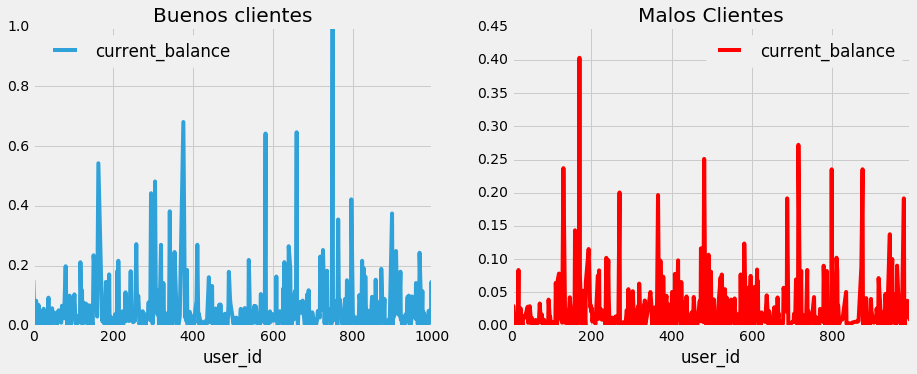

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
buenos_clientes.plot(x="user_id", y=["current_balance"], title="Buenos clientes",kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["current_balance"], title="Malos Clientes",kind="line",color='red', ax=axes[1])


Deuda:  Aqui vemos que si __los buenos tiene mayor deuda__, seguramente como comentamos en la grafica de Deficit-Superavit, 
mayores ingresos permiten el tomar una deuda mayor. 

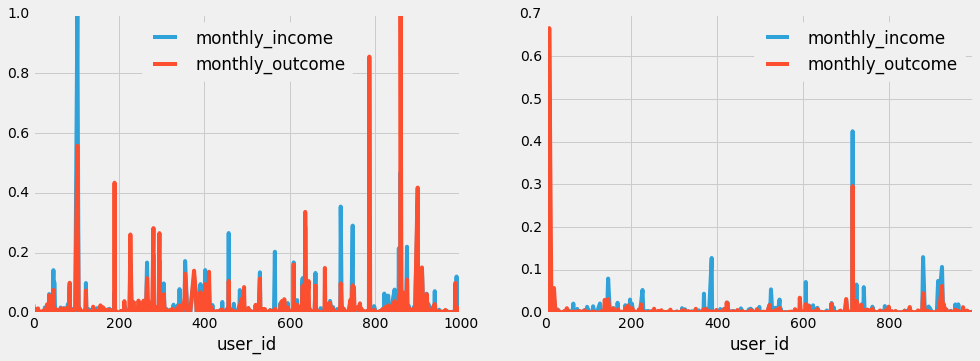

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["monthly_income","monthly_outcome"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["monthly_income","monthly_outcome"], kind="line", ax=axes[1])

__Parece que los buenos tienen un mayor ingreso (no demasiado) en general que los malos. 
Y definitvamente gastan mucho mas.__ 
Un reporte reciente de Credit Sesame  indica que salarios altos son un factor positivo para
el score de credito ya que se puede adquirir una deuda mas grande y se puede pagar mas rapido.
Tener un income alto representa un riesgo menor para adquirir un prestamo. 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py

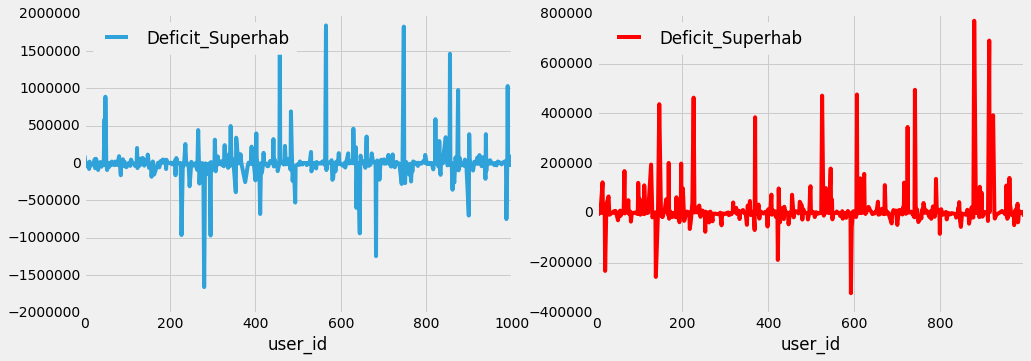

In [25]:
#Eliminating outliers
buenos_clientes.Deficit_Superhab[abs(buenos_clientes.Deficit_Superhab) >2000000] = 0
malos_clientes.Deficit_Superhab[abs(malos_clientes.Deficit_Superhab) >1000000] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["Deficit_Superhab"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["Deficit_Superhab"], kind="line",color='red', ax=axes[1])

No normalize porque la informacion se aprecia bien a esta escala despues de eliminar outliers manualmente. 
Los buenos clientes tienen superavits y deficits mayores que los malos. La variancia es mayor para los buenos.

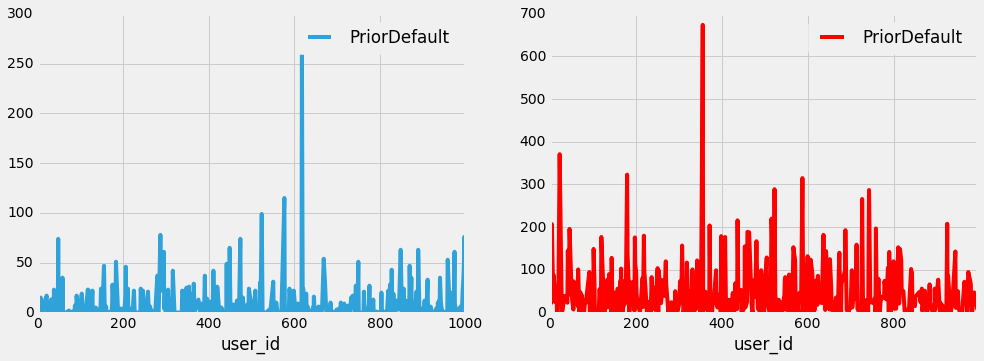

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["PriorDefault"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["PriorDefault"], kind="line",color='red', ax=axes[1])

*Parece que si existe un patron certero*: clientes malos tiene muchisimos mas pagos vencidos en su 
    historial de credito que los considerados buenos consumidores. El orden del promedio es 
    mayor para los malos. __No calcule el promedio porque los outliers generan sesgo, y lo
    mismo aplica para las otras variables__. Creo que es mejor apreciar el patron en forma grafica
    cuandos e hace una estimacion visual. 

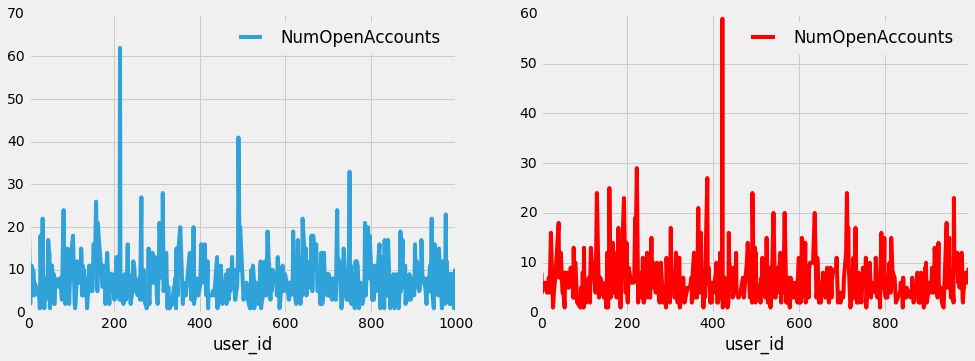

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["NumOpenAccounts"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["NumOpenAccounts"], kind="line",color='red', ax=axes[1])


Ademas de algunos outliers no distingo un patron especial respecto a una y otra categoria.
No parece haber una correlacion especifica entre el promedio de cuentas abiertas y el riesgo
crediticio de ser buen o al cliente. 

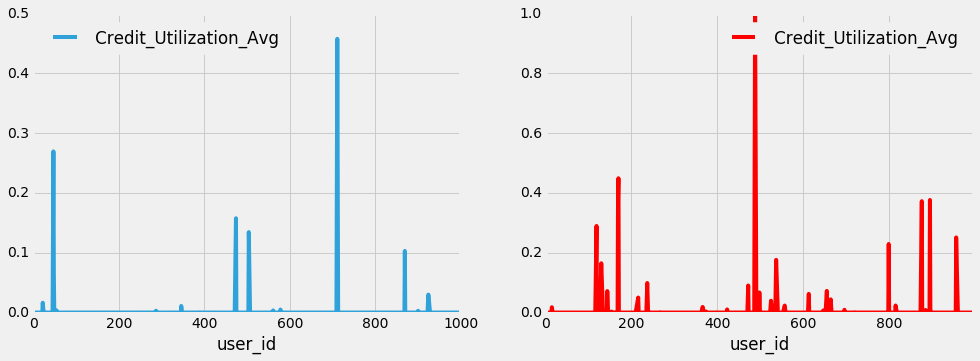

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["Credit_Utilization_Avg"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["Credit_Utilization_Avg"], kind="line",color='red', ax=axes[1])

Otra variable que genere es el Credit Utilization, que es la proprocion 
de credito utilizado del credito disponible, es decir el ratio del total que se debe
en todas las cuentas abiertas y la suma total de los limites de credito. Aqui
solo considere cuentas con limite de credito, las que no se asigna 0.0. Tome el
promedio de todas estas cuentas. Ahora al final tuve que normalizar porque muchas cuentas 
tienen el balance mayor al limite de credito! e.g cifras como  257%, super overdraft! 
Lo unico que me interesa es como se compara la utilizacion entre buenos y malos. 
De las graficas veo que __los malos usan mas credito que los buenos__, haciendo a 
un lado los outliers. Esto tiene sentido porque los malos usan mas credito. 
De acuerdo a un estudio de Experian __una utilizacion significativa  es un signo de
alto riesgo de credito__, solo menor a tu historial de pagos de credito.

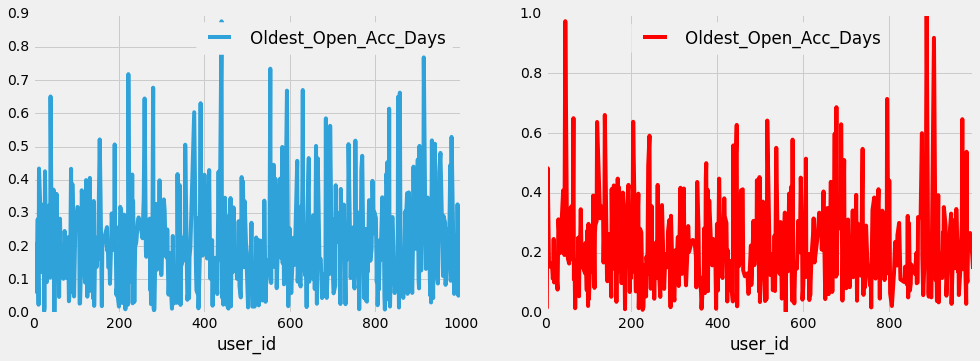

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["Oldest_Open_Acc_Days"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["Oldest_Open_Acc_Days"], kind="line",color='red', ax=axes[1])

Normalizamos para apreciar mejor que los malos clientes tiene cuentas de mayor longevidad en general. 

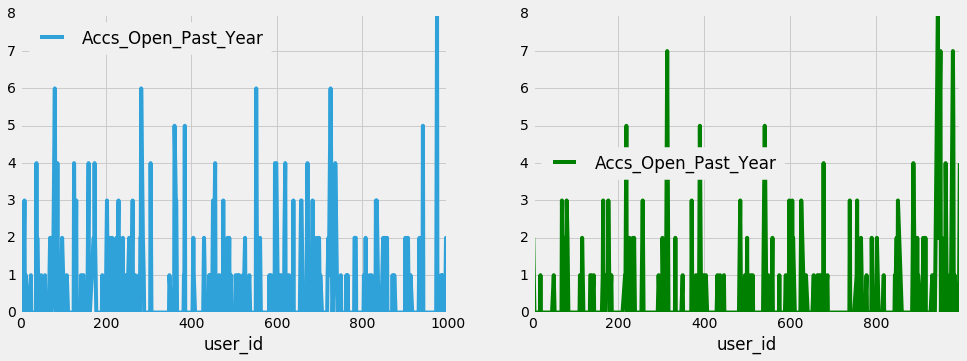

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
buenos_clientes.plot(x="user_id", y=["Accs_Open_Past_Year"], kind="line",ax=axes[0])
malos_clientes.plot(x="user_id", y=["Accs_Open_Past_Year"], kind="line",color='green', ax=axes[1])

En general parece que los usuarios malos tiene menos cuentas abiertas durante los ultimos 365 dias.
No se si se deba a que al ser malos les es precisamente dificil obtener nuevas fuentes de credito. 
Creo que la diferencia, aunque evidente, quiza no sea lo suficientemente marcada para usar este 
parametro como un discriminador del tipo de usuario. 


In [31]:
#Lets normalize all variables so they share the sam scale for the classifier 
max_value = mydata2['Deficit_Superhab'].max()
min_value = mydata2['Deficit_Superhab'].min()
mydata2['Deficit_Superhab'] = (mydata2['Deficit_Superhab'] - min_value) / (max_value - min_value)
    
mydata2.head(10)

,user_id,monthly_income,monthly_outcome,class,Deficit_Superhab,current_balance,Credit_Utilization_Avg,PriorDefault,Oldest_Open_Acc_Days,Accs_Open_Past_Year,NumOpenAccounts,NumInstitutions
0,0,0.027326,0.015533,1,0.646794,0.152462,0.000022,10.0,0.077429,2,20,7
1,1,0.000957,0.000081,0,0.637897,0.080944,0.000014,143.0,0.345421,0,8,4
2,2,0.001224,0.000340,0,0.637894,0.002575,0.000000,20.0,0.013442,2,4,1
3,3,0.001834,0.004877,1,0.634315,0.003759,0.000035,0.0,0.169000,0,2,1
4,5,0.000018,0.000537,0,0.636668,0.029703,0.000020,207.0,0.483058,0,5,3
5,6,0.011949,0.011116,1,0.637445,0.026802,0.000022,0.0,0.205895,0,11,5
6,7,0.000671,0.004561,1,0.633590,0.082944,0.000014,15.0,0.062377,0,9,6
7,8,0.003392,0.000310,0,0.639803,0.001563,0.000003,26.0,0.167810,0,5,4
8,9,0.256961,0.666312,0,0.256681,0.006578,0.000024,88.0,0.154229,0,6,2
9,10,0.002458,0.008365,1,0.631696,0.038289,0.000007,0.0,0.281224,3,10,6


La columna *NumInstitutions* lo inclui en caso de que resultara relevante de alguna forma, pero en este punto no le adjudico 
ningun significado especial.


# Modelo de Clasificacion

A continuacion vamos a utilizar las bibliotecas de sklearn para crear un modelo 
de clasificacion binaria (bueno/malo cliente) de acuerdo a las variables que
creamos, las cuales representan nuestro criterio o business model para elegir a un
cliente y otorgarle un prestamo.

Notese que este no es un problema en el que busquemos predecir, inferir, interpolar
o calcular el valor de una variable en funcion de cierta optimizacion de parametros. 
Lo que queremos es adjudicar la membresia a los consumidores de nuestro dataset en cierta
categoria. No tenemos muchos parametros ni el dataset es muy grande, asi que vamos a ver 
que metricas podemos lograr.

Vamos a cargar las bibliotecas de sklearn que necesitamos:

In [32]:
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# aqui tuve que instalar  pip install sklearn-pandas
from ggplot import *
from sklearn import metrics
#i had to sudo pip install statsmodels --upgrade

/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Al principio no inclui las columnas *NumOpenAccounts, Accs_Open_Past_Year, NumOpenAccounts* y *NumInstitutions*
porque pense que su impacto seria superfluo, pero no, al experimentar con regresion logistica el
performance mejoro muchoo, y para los demas algoritmos hubo una mejora
aunque mas modesta. Vamos a dividir nuestra variables en numericas y categoricas.

Solo tenemos variables categoricas y las etiquetas que venian de users.csv:

In [33]:
columnas_numericas=['user_id','monthly_income','monthly_outcome','Deficit_Superhab','current_balance',\
                    'Credit_Utilization_Avg','PriorDefault','Oldest_Open_Acc_Days',\
                    'Accs_Open_Past_Year','NumOpenAccounts','NumInstitutions']

In [34]:
#Check we dont have nulls
mydata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 0 to 990
Data columns (total 12 columns):
user_id                   991 non-null int64
monthly_income            991 non-null float64
monthly_outcome           991 non-null float64
class                     991 non-null int64
Deficit_Superhab          991 non-null float64
current_balance           991 non-null float64
Credit_Utilization_Avg    991 non-null float64
PriorDefault              991 non-null float64
Oldest_Open_Acc_Days      991 non-null float64
Accs_Open_Past_Year       991 non-null int64
NumOpenAccounts           991 non-null int64
NumInstitutions           991 non-null int64
dtypes: float64(7), int64(5)
memory usage: 100.6 KB


In [35]:
X=np.array(mydata2[columnas_numericas])
y=np.array(mydata2['class'])

Aqui usamos sklearn para dividir el dataset en 2/3 Entrenamiento y 1/3 Test, con cierta semilla aleatoria y 
estratificando los datos para el 'split':

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

# Evaluacion de la Clasificacion

El entrenamiento del modelo y su evaluacion se traslapan un poco. Espero resulte claro el flujo
de trabajo de este notebook.

Vamos a probar varios algoritmos de clasificacion de sklearn para ver cual nos da el mejor
rendimiento (mean Accuracy). Ademas de este indicador vamos a graficar la curva ROC para cada uno de 
los  clasificadores. 

In [37]:
LR = LogisticRegression(verbose=2)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)


[LibLinear]

0.7530487804878049

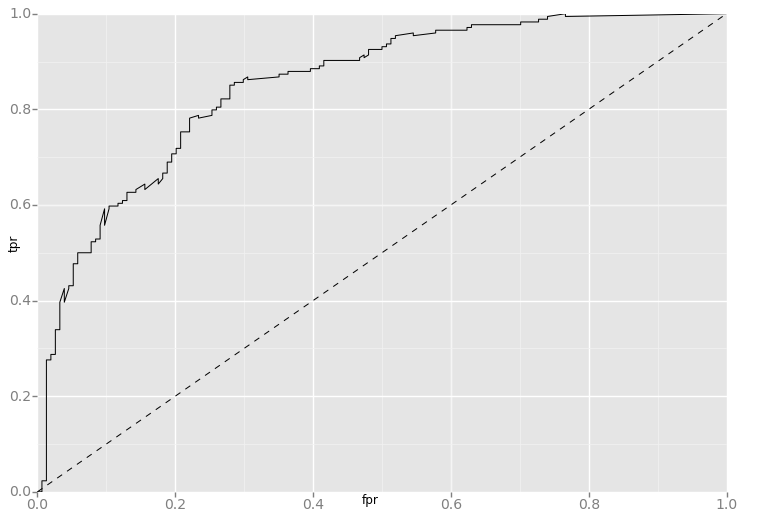

<ggplot: (8762835780729)>


In [38]:
predictions = LR.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test, predictions)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
df.head(5)
#ggplot con cara de R
rocg=ggplot(df, aes(x='fpr', y='tpr')) +geom_line() +geom_abline(linetype='dashed')
print(rocg)

In [39]:
Grad = GradientBoostingClassifier(n_estimators=100)
Grad.fit(X_train, y_train)
Grad.score(X_test, y_test)

0.7652439024390244

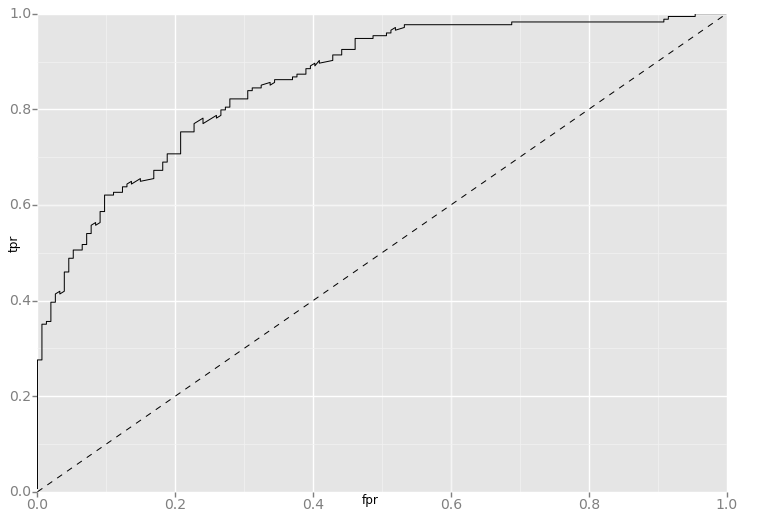

<ggplot: (8762835713553)>


In [40]:
predictions = Grad.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test, predictions)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
df.head(5)
#ggplot con cara de R
rocg=ggplot(df, aes(x='fpr', y='tpr')) +geom_line() +geom_abline(linetype='dashed')
print(rocg)

In [41]:
Arbol=DecisionTreeClassifier()
parameters = {'max_depth':[5, 10, 15, 20, 25, 32]}
dtree_gs = GridSearchCV(Arbol, parameters, cv=5)
dtree_gs.fit(X_train, y_train)
print(dtree_gs.score(X_test, y_test))


0.7408536585365854


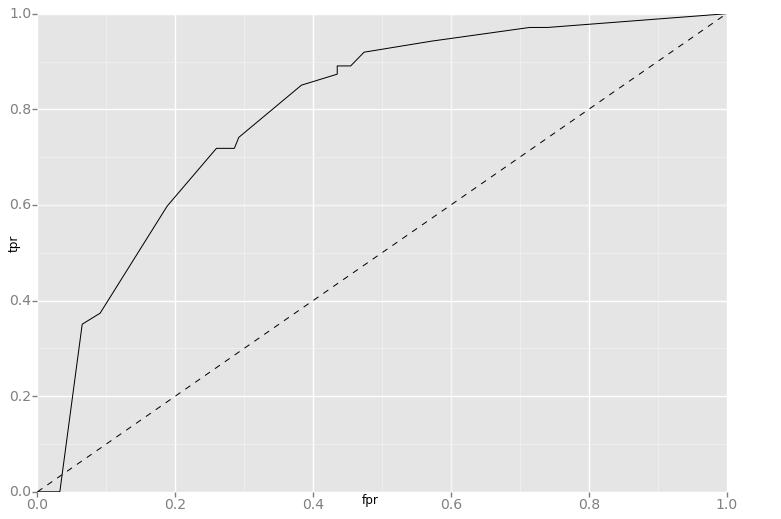

<ggplot: (8762835700277)>


In [42]:
predictions = dtree_gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test, predictions)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
df.head(5)
#ggplot con cara de R
rocg=ggplot(df, aes(x='fpr', y='tpr')) +geom_line() +geom_abline(linetype='dashed')
print(rocg)

In [43]:
ranfo=RandomForestClassifier()
parameters = {'max_depth':[5, 15], 'n_estimators':[10,30]}
rf_gs = GridSearchCV(ranfo, parameters)
rf_gs.fit(X_train, y_train)
print(rf_gs.score(X_test, y_test))


0.7926829268292683


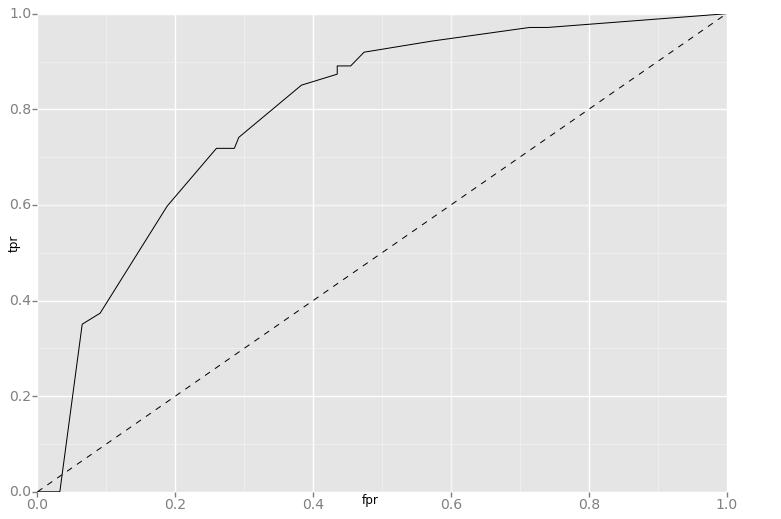

<ggplot: (8762835710221)>


In [44]:
predictions_rf = rf_gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test, predictions)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
df.head(5)
#ggplot con cara de R
rocg=ggplot(df, aes(x='fpr', y='tpr')) +geom_line() +geom_abline(linetype='dashed')
print(rocg)

La mejor  "mean Accuracy" es para el bosque aleatorio , aprox. 79% Todas als cuercas ROC se ven 
razonablemente aceptables. Tambien es posible usar la metrica del area bajo la curva (AUC), entre mas area
mejor es el clasificador. Dado el tamanio del dataset de entrenamiento y el numero de parametros 
parece que la clasificacion es razonablemente aceptable. 

Es posible guardar al modelo entrenado en serializacion de pickle para uso futuro en produccion 
por ejemplo, donde puede clasificar y estimar scores de credito en datos no vistos anteriormente. 

## Deployment

Vamos a recuperar los 328 clientes y establezco un __umbral del 60% de probabilidad__ para considerar
a una prediccion positiva como buen cliente.

In [45]:
X_test.shape


(328, 11)

In [46]:
testers = pd.DataFrame(data=X_test)
testers.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,873.0,0.002683,0.000244,0.639248,0.088130,0.000040,51.0,0.319308,0.0,4.0,4.0
1,994.0,0.001949,0.003355,0.635793,0.011394,0.000039,22.0,0.050756,0.0,1.0,1.0
2,639.0,0.000937,0.000632,0.637380,0.006595,0.000021,0.0,0.016522,3.0,4.0,3.0
3,141.0,0.003253,0.002867,0.637366,0.057810,0.000015,0.0,0.335900,0.0,11.0,6.0
4,44.0,0.003661,0.002653,0.637915,0.014584,0.000015,42.0,0.192593,0.0,8.0,7.0
5,936.0,0.007552,0.006256,0.638030,0.019060,0.000015,10.0,0.439863,1.0,7.0,5.0
6,703.0,0.000234,0.000018,0.637326,0.005592,0.000032,99.0,0.245309,0.0,3.0,3.0
7,478.0,0.008937,0.005631,0.639798,0.023769,0.000027,37.0,0.224167,0.0,9.0,5.0
8,693.0,0.004716,0.004143,0.637481,0.009670,0.000029,0.0,0.254971,2.0,5.0,2.0
9,42.0,0.000023,0.000014,0.637146,0.004076,0.000001,145.0,0.208135,0.0,7.0,5.0


In [72]:
probas = pd.DataFrame(data=predictions_rf)
probas.head(10)

,0
0,0.171404
1,0.450826
2,0.676765
3,0.819244
4,0.197519
5,0.644633
6,0.070704
7,0.402870
8,0.785599
9,0.057178


In [73]:
testers['probas']=probas

In [74]:
testers.head(10)

,0,1,2,3,4,5,6,7,8,9,10,probas,Candidato
0,873.0,0.002683,0.000244,0.639248,0.088130,0.000040,51.0,0.319308,0.0,4.0,4.0,0.171404,M
1,994.0,0.001949,0.003355,0.635793,0.011394,0.000039,22.0,0.050756,0.0,1.0,1.0,0.450826,M
2,639.0,0.000937,0.000632,0.637380,0.006595,0.000021,0.0,0.016522,3.0,4.0,3.0,0.676765,B
3,141.0,0.003253,0.002867,0.637366,0.057810,0.000015,0.0,0.335900,0.0,11.0,6.0,0.819244,B
4,44.0,0.003661,0.002653,0.637915,0.014584,0.000015,42.0,0.192593,0.0,8.0,7.0,0.197519,M
5,936.0,0.007552,0.006256,0.638030,0.019060,0.000015,10.0,0.439863,1.0,7.0,5.0,0.644633,B
6,703.0,0.000234,0.000018,0.637326,0.005592,0.000032,99.0,0.245309,0.0,3.0,3.0,0.070704,M
7,478.0,0.008937,0.005631,0.639798,0.023769,0.000027,37.0,0.224167,0.0,9.0,5.0,0.402870,M
8,693.0,0.004716,0.004143,0.637481,0.009670,0.000029,0.0,0.254971,2.0,5.0,2.0,0.785599,B
9,42.0,0.000023,0.000014,0.637146,0.004076,0.000001,145.0,0.208135,0.0,7.0,5.0,0.057178,M


Aplicamos el umbral de 60% de probabilidad para ser un usuario Bueno, B:

In [75]:
testers['Candidato'] = np.where(testers['probas']>=0.60, 'B', 'M')

In [84]:
testers.head(10)

,0,1,2,3,4,5,6,7,8,9,10,probas,Candidato
0,873.0,0.002683,0.000244,0.639248,0.088130,0.000040,51.0,0.319308,0.0,4.0,4.0,0.171404,M
1,994.0,0.001949,0.003355,0.635793,0.011394,0.000039,22.0,0.050756,0.0,1.0,1.0,0.450826,M
2,639.0,0.000937,0.000632,0.637380,0.006595,0.000021,0.0,0.016522,3.0,4.0,3.0,0.676765,B
3,141.0,0.003253,0.002867,0.637366,0.057810,0.000015,0.0,0.335900,0.0,11.0,6.0,0.819244,B
4,44.0,0.003661,0.002653,0.637915,0.014584,0.000015,42.0,0.192593,0.0,8.0,7.0,0.197519,M
5,936.0,0.007552,0.006256,0.638030,0.019060,0.000015,10.0,0.439863,1.0,7.0,5.0,0.644633,B
6,703.0,0.000234,0.000018,0.637326,0.005592,0.000032,99.0,0.245309,0.0,3.0,3.0,0.070704,M
7,478.0,0.008937,0.005631,0.639798,0.023769,0.000027,37.0,0.224167,0.0,9.0,5.0,0.402870,M
8,693.0,0.004716,0.004143,0.637481,0.009670,0.000029,0.0,0.254971,2.0,5.0,2.0,0.785599,B
9,42.0,0.000023,0.000014,0.637146,0.004076,0.000001,145.0,0.208135,0.0,7.0,5.0,0.057178,M


In [77]:
finales=testers.loc[testers['Candidato'] == 'B']

In [78]:
print('Tenemos {} clientes seleccionados para candidatos al prestamo.'.format(*finales.shape)) 

Tenemos 153 clientes seleccionados para candidatos al prestamo.


In [93]:
finales.rename(
  columns={
    0 : 'user_id',
    1 : 'monthly_income'
  },
  inplace=True
)

finales[['user_id','Candidato']].head(5)


,user_id,Candidato
2,639.0,B
3,141.0,B
5,936.0,B
8,693.0,B
10,875.0,B


 Podriamos incluir a los clientes etiquetados como Buenos en el dataset de entrenamiento.

## Propose an amount to be lended to those clients and a term in which the loan will need to be paid back.
De nuevo me apoyo en mis experiencias para desarollar una estrategia para estas respuesta:
    Dado que estos __clientes representan bajo riesgo__ despues de la clasificacion llevada a cabo,
podemos asignar una cantidad significativa al prestamo, digamos entre $100,000  y $500,000 MXN (Tipico
 por ejemplo en mi experiencia de un prestamo de nomina).
Vamos a proponer $100,000. Los factotres que permiten prestar tanto como sea posible son los que
usamos en el criterio de clasificacion: ingreso, deuda, histrial de credito, etc. Si es un prestamo
personal tampoco hay colateral para asegurarlo pero por eso seleccionamos al cliente con cuidado.

Normalmente prestamos a clientes riesgoso se hacen a corto plazo y con alto interes. En este caso
dadas las caracteristicas de nuestro cliente de bueno, se le puede ofrecer un term largo de pago
y bajos intereses. Esto le permite acceder a cantidades mayores de credito, en forma mas segura 
y planificable. Propongo un term de entre 1 y 3 anios. Durante este tiempo el prestamo se amortizara,
es decir el pirnciopal (sin contar el interes) se va a pagar en forma completa en forma distribuida 
sobre el tiempo. Para los $100,000 puede ser 1 anio con pagos mensuales. 

## Finally choose an anual interest rate the lended amount must have in order to be profitable

Para asignar una tasa de interes sigamos un modelo simple de loan-pricing donde tomamos en cuenta:
    - El costo de financiamiento para conseguir los fondos para prestar, por ejemplo en bancos 
    se usan depositos de clientes , o mercados de inversion.
    - Costos operacionales: procesamiento de la solicitud, sueldos, renta etc.
    - Un premium de riesgo
    - Un margen de ganancia
    
    Para los $100,000 MXN propuestos el obtener fondos es un 5%, default risk 2% (este puede
ser menor dado que estos clientes estan escogidos como confiables) mas 2% de costos de operacion.
Un marge de ganancia tipico en estos prestamos de la industria bancaria es 1%, segun 
mi investigacion. Asi que en total tenemos :
    
    costo de financiamiento+riesgo de default+costos operacionales++profit margin= 5+2+2+1=10%
    
    __Minetras las perdidas no rebasen el premium de riesgo, podemos tener una ganancia y mas si
    se aumenta el numero de prestamos. 